In [1]:
import pandas as pd
import numpy as nm
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
from pyspark.sql.functions import col, column
from pyspark.sql.functions import expr
from pyspark.sql.functions import split
from pyspark.sql import Row
import csv
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, IndexToString, StandardScaler, PCA
from pyspark.ml.classification import DecisionTreeClassifier

---

## Initialize a SparkSession, define the csv Schema

In [2]:
ss = SparkSession.builder.appName("Project").getOrCreate()

In [3]:
schema = StructType([ StructField("ID", IntegerType(), False ), \
                        StructField("Case Number", StringType(), False), \
                        StructField("Date", StringType(), False ), \
                        StructField("Block", StringType(), False ), \
                        StructField("IUCR", StringType(), False), \
                        StructField("Primary Type", StringType(), False), \
                        StructField("Description", StringType(), False),\
                        StructField("Location Description", StringType(), False), \
                        StructField("Arrest", StringType(), False), \
                        StructField("Domestic", StringType(), False), \
                        StructField("District", StringType(), False) ,\
                        StructField("Ward", StringType(), False ), \
                        StructField("Community Area", StringType(), False ), \
                        StructField("FBI Code", StringType(), False), \
                        StructField("Year", StringType(), False), \
                        StructField("Latitude", StringType(), False),\
                        StructField("Longitude", StringType(), False)
                           ])

In [4]:
# new_file3.csv is the file generated by using Suvarna's code
data = ss.read.csv("./new_file3.csv",schema=schema,header=True, inferSchema=False)

In [5]:
data = data.drop('Case Number').drop('ID')

---

## Apply PCA Reduction (for model training only, not for visualization)
#### Reason: I tried directly using Lab8's code before. However, I continously got an error saying the data's cardinality is too high and aborted the task, which means the dataset's size is too large. To reduce the dataset's size, I need to use PCA reduction first to reduce the size and then use the reduced data to train the model.

`Step 1: Transforms a column of string to a new column of index (type double)`

In [6]:
# This block will create a new column for each indexed column, for example, will create a 'i_date' for indexed 'Date' column
columns_to_index = ["Date", "Primary Type", "Description", "IUCR","Year","Block",
                    "Location Description", "Arrest", "Domestic", "District","Ward","FBI Code","Community Area", 
                    "Latitude", "Longitude"]
label_indexers = {col: StringIndexer(inputCol=col, outputCol=f"i_{col.replace(' ', '_').lower()}").fit(data) for col in columns_to_index}

In [7]:
# This block will transform data
transformed_data = data
for indexer in label_indexers.values():
    transformed_data = indexer.transform(transformed_data)

In [8]:
# data2 will contain the indexed values only, which means they are all integer -> ready for training
data2 = transformed_data.select("i_date","i_iucr","i_primary_type","i_description","i_location_description",\
                    "i_arrest","i_year","i_block","i_domestic","i_district","i_ward","i_fbi_code","i_community_area","i_latitude","i_longitude")

In [9]:
input_features = ["i_date","i_iucr","i_primary_type","i_description","i_location_description","i_year","i_block",\
                    "i_domestic","i_district","i_ward","i_fbi_code","i_community_area","i_latitude","i_longitude"]

`Step 2: Create a vector-assembler to combine individual features into a vector in a new column, which called 'features_for_arrest'.`

In [10]:
assembler = VectorAssembler(inputCols=input_features, outputCol="features_for_arrest")

In [11]:
assembled_data = assembler.transform(data2)

`Step 3: Use a StandardScaler to center the data - saved the centered data into a new column called "scaled_features"`

In [12]:
scaler = StandardScaler(inputCol="features_for_arrest", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

In [13]:
# When k=9, its variance is closest to 0.9 && > 0.9
pca = PCA(k=9,inputCol="scaled_features",outputCol="pcaFeatures")
model = pca.fit(scaled_data)
result = model.transform(scaled_data)
explained_variance = model.explainedVariance
print("Explained Variance: ", sum(explained_variance))

Explained Variance:  0.9064204185937147


`By that, We got the PCA reduction data: result `

---

## Train the model

####  Train the model with the reduced data. I used RandomForestClassifier instead of PySpark DecisionTree.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [15]:
# Convert PySpark DataFrame to Pandas DataFrame
# "pcaFeatures" is the hyperparameter that predicts arrest or not
# "i_arrest" is our target variable
pandas_df = result.select("pcaFeatures", "i_arrest").toPandas()

In [16]:
# Extract PCA features and target variable
X = pandas_df["pcaFeatures"].tolist()
y = pandas_df["i_arrest"].tolist()

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
# Standardize the data again just in case
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Train the RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

RandomForestClassifier()

`Above is the model that predicts the value of Arrest`

In [20]:
# Make predictions on the test set
predictions = model.predict(X_test_scaled)

---

## Evaluate the model

In [21]:
# Use test_data to evaluate our model 
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 89.40%


## Visualize the prediction

#### Graph 1: confusion matrix

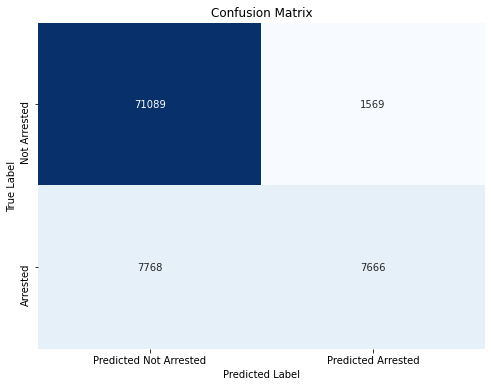

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Convert to DataFrame for better visualization
conf_df = pd.DataFrame(conf_matrix, index=['Not Arrested', 'Arrested'], columns=['Predicted Not Arrested', 'Predicted Arrested'])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Graph 2: precision-recall curve, which shows trade-off between sensitivity (true positive rate) and specificity (true negative rate) for different threshold values

`a good ROC curve should be pushed towards the upper-left corner, indicating high sensitivity and low false positive rate`

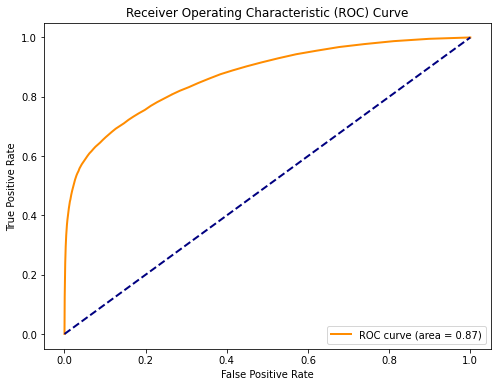

In [23]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for class 1
y_scores = model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()